# Using CNNs to Improve GeoGuessr Gameplay
### Shashidhar Gollamudi, Raveesh Mehta, Jason Cheung

In this notebook, we train a Convolutional Neural Network (CNN) using the Mapillary Street-level Sequences Dataset (https://www.mapillary.com/dataset/places), which contains ~1.6 million street view images of 30 cities around the world. The goal of this CNN is to predict the city that a certain image belongs to given nothing but the image. 



In [18]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
import numpy as np
from tensorflow.keras.preprocessing import image
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
from scipy.ndimage import zoom
import keras
import matplotlib as mpl
from PIL import Image
from matplotlib import image as mpimg
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import tkinter
from tkinter import filedialog

In [19]:
# global variables
dataset_path = './MiniData'
input_shape = (640, 360, 3)
batch_size = 32
epochs = 1
learning_rate = 0.001

In [20]:
# generators to get images from source folders
data_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_generator = data_generator.flow_from_directory(
    dataset_path,
    target_size=(input_shape[0], input_shape[1]),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)
val_generator = data_generator.flow_from_directory(
    dataset_path,
    target_size=(input_shape[0], input_shape[1]),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 2400 images belonging to 30 classes.
Found 600 images belonging to 30 classes.


## Hyperparameter Search
Before training on the full dataset, we need to find the optimal hyperparameters to train our model with. For this project we look at learning rate and dropout rate using a manual grid search implementation. The architecture for the search and final models is explained in the next section.

Resources:
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html 
- https://towardsdatascience.com/gridsearchcv-for-beginners-db48a90114ee 
- https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/ 

In [21]:
# Define a function to create and compile the model
def create_model(learning_rate=0.001, dropout_rate=0.5):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(len(train_generator.class_indices), activation='softmax'))

    model.compile(optimizer=Adam(learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

model = KerasClassifier(build_fn=create_model, epochs=epochs, batch_size=batch_size, verbose=0)

param_grid = {
    'learning_rate': [0.001, 0.01, 0.1],
    'dropout_rate': [0.2, 0.5, 0.8]
}

# Iterate through all combinations in the parameter grid
for learn in param_grid['learning_rate']:
    for drop in param_grid['dropout_rate']:
        print(f"learning rate: {learn}, dropout: {drop}")
        searchModel = create_model(learning_rate=learn, dropout_rate=drop)
        searchModel.fit(
            train_generator,
            steps_per_epoch=train_generator.samples // batch_size,
            validation_data=val_generator,
            validation_steps=val_generator.samples // batch_size,
            epochs=epochs
        )

learning rate: 0.001, dropout: 0.2
75/75 [==============================] - 10s 117ms/step - loss: 3.8411 - accuracy: 0.0838 - val_loss: 3.1916 - val_accuracy: 0.1389
learning rate: 0.001, dropout: 0.5
75/75 [==============================] - 9s 118ms/step - loss: 3.7569 - accuracy: 0.0683 - val_loss: 3.2534 - val_accuracy: 0.1007
learning rate: 0.001, dropout: 0.8
75/75 [==============================] - 9s 118ms/step - loss: 3.9937 - accuracy: 0.0358 - val_loss: 3.3490 - val_accuracy: 0.0451
learning rate: 0.01, dropout: 0.2
75/75 [==============================] - 9s 117ms/step - loss: 20.0014 - accuracy: 0.0246 - val_loss: 3.4014 - val_accuracy: 0.0330
learning rate: 0.01, dropout: 0.5
75/75 [==============================] - 9s 116ms/step - loss: 14.6296 - accuracy: 0.0246 - val_loss: 3.4011 - val_accuracy: 0.0347
learning rate: 0.01, dropout: 0.8
75/75 [==============================] - 9s 114ms/step - loss: 20.6558 - accuracy: 0.0262 - val_loss: 3.4017 - val_accuracy: 0.0312
lea

# Training on full data set
With the optimal hyperparameters established, we can now train a model on the full dataset. After initializing and training the model, we save it as "oneEpochTrainedModel.h5." To test our model, you can upload an image inside this directory and change "image_path" to the desired path. 

Architecture
- Convolutional layer (Conv2D) - Applies convolutional filters to given images, learning progressively larger and more complex images as you move through the network.
- Max Pooling Layer (MaxPooling2D) - Reduces the dimensions of the image, making learning more efficient
- Flatten layer (Flatten) - Converts pooled information into 1 dimension to be fed to the dense layer
- Dense layer (Dense) - Takes features from the previous layers and learns the patterns and relationships between them
- Dropout layer (Dropout) - Randomly drops certain nodes, helping to prevent overfitting

Resources:
- https://towardsdatascience.com/convolutional-neural-networks-explained-9cc5188c4939 
- https://towardsdatascience.com/building-a-convolutional-neural-network-cnn-in-keras-329fbbadc5f5 

In [4]:
# intiliaze CNN with convolutional and pooling layers
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(len(train_generator.class_indices), activation='softmax'))

In [5]:
# compile model
model.compile(optimizer=Adam(learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

In [6]:
# train model
# ~3.5 hours per training epoch on 1.6m images on RTX 4070
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    epochs=epochs
)

38173/38173 [==============================] - 11852s 310ms/step - loss: 0.8280 - accuracy: 0.7729 - val_loss: 0.4333 - val_accuracy: 0.8811


In [8]:
# save model
model.save('oneEpochTrainedModel.h5')

In [13]:
loaded_model = load_model('oneEpochTrainedModel.h5')

In [7]:
# predict a given image
image_path = './Sample Images/Illinois.png'

# Load and preprocess the image
img = image.load_img(image_path, target_size=(input_shape[0], input_shape[1]))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Rescale to match the training data preprocessing

# Make the prediction
prediction = loaded_model.predict(img_array)

# Get the predicted class index
predicted_class_index = np.argmax(prediction)

# Get the class label
class_labels = list(train_generator.class_indices.keys())
predicted_class_label = class_labels[predicted_class_index]

# Print the prediction result
print(f'Predicted class: {predicted_class_label}')
print(f'Prediction scores: {prediction}')

Predicted class: ottawa
Prediction scores: [[2.6706061e-14 4.1085418e-04 1.3020258e-07 1.3560937e-03 6.3748193e-05
  1.2186784e-03 1.9342933e-02 2.4471939e-05 9.8543800e-03 1.2480613e-04
  1.3829027e-04 1.5893698e-01 9.0089822e-03 9.2451312e-03 1.5808419e-04
  1.3639887e-05 9.6299946e-02 8.7845990e-07 7.8148715e-02 5.7676580e-10
  5.6241870e-01 4.9742022e-05 3.3019301e-02 6.5311650e-04 8.5470505e-04
  6.2940858e-04 4.2495227e-05 1.7151603e-02 6.9979683e-04 1.3433496e-04]]


## Generate Confusion Matrix
In this section, we generate a confusion matrix to analyze the model's accuracy on various classes. We chose to use a small subset of data to generate this matrix due to time and computing constraints. As a result, the matrix is a sparse analysis of all the classes.

Resources:
- https://www.w3schools.com/python/python_ml_confusion_matrix.asp 
- https://www.kdnuggets.com/2021/02/evaluating-deep-learning-models-confusion-matrix-accuracy-precision-recall.html 

Found 15252 images belonging to 30 classes.


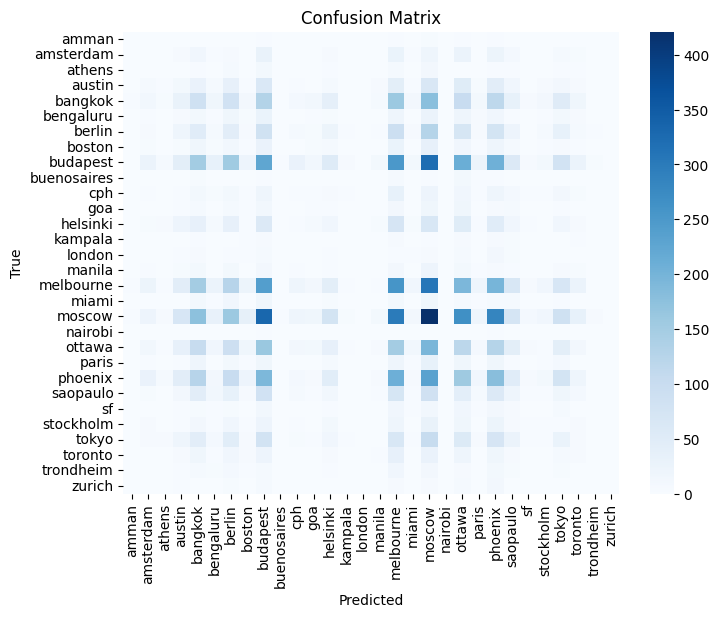

In [26]:
# Function to generate confusion matrix
def generate_confusion_matrix(model, generator):
    # Get true labels
    y_true = generator.classes

    # Generate predictions
    y_pred = model.predict(generator)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)

    # Plot confusion matrix as heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, fmt='d', cmap='Blues', xticklabels=generator.class_indices, yticklabels=generator.class_indices)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# create a smaller validation set to generate a confusion matrix
data_generator = ImageDataGenerator(rescale=1./255, validation_split=0.01)
confusion_generator = data_generator.flow_from_directory(
    dataset_path,
    target_size=(input_shape[0], input_shape[1]),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Use the function to generate confusion matrix
generate_confusion_matrix(model, confusion_generator)

## Generate Heatmaps
Here we generate a heatmap overlayed on a given image to represent what our model "looks" at to make its prediction. We use the Gradient Class Activation Mapping techique (GradCAM) to get this information as a heatmap, then superimpose it onto an image. The final image is then saved as "cam.jpg" in this directory. To change the selected image, change the variable "heatmap_img_path" to that of the desired image.

**Note: The implementation for this code is based on the Keras tutorial found here: https://keras.io/examples/vision/grad_cam/

Resources:
- https://www.sciencedirect.com/topics/computer-science/gradient-weighted-class-activation-mapping
- https://keras.io/examples/vision/grad_cam/
- https://www.kaggle.com/code/aakashnain/what-does-a-cnn-see 
- https://medium.com/analytics-vidhya/visualizing-activation-heatmaps-using-tensorflow-5bdba018f759 

Predicted class: bangkok


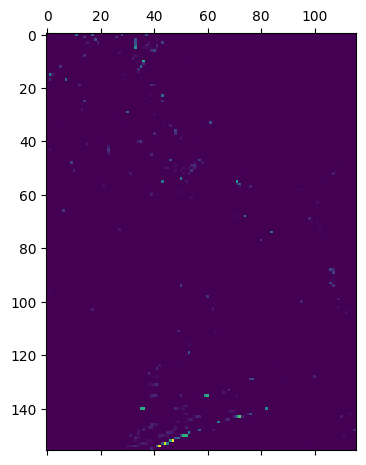

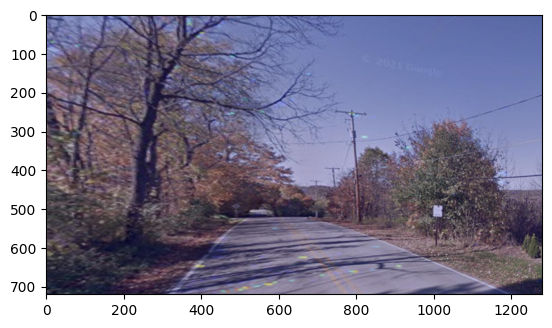

In [14]:
img_size = (640, 360)

last_conv_layer_name = "conv2d_2"
heatmap_img_path = "./Sample Images/Illinois.png"

# convert the image to an array
def get_img_array(img_path, size):
    img = image.load_img(img_path, target_size=size)
    array = image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

# generate heatmap to be overlayed onto image
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # tensorflow library that computes gradients automatically
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # extract weights of featurews from last layer of output
    last_conv_layer_output = last_conv_layer_output[0]

    # matrix multiplication of last layer and gradients
    # see https://keras.io/examples/vision/grad_cam/ for info
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# load and overlay heatmap onto image
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = image.load_img(img_path)
    img = image.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)

    # transform weights into colormap
    jet = mpl.colormaps["jet"]

    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = image.img_to_array(jet_heatmap)

    # superimpose given heatmap onto image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = image.array_to_img(superimposed_img)

    superimposed_img.save(cam_path)

    cam_image = mpimg.imread(cam_path)
    plt.imshow(cam_image)
    plt.show()

# predict class of given image
img_array = preprocess_input(get_img_array(heatmap_img_path, size=img_size))
model = loaded_model
model.layers[-1].activation = None
prediction = loaded_model.predict(img_array)
predicted_class_index = np.argmax(prediction)

class_labels = list(train_generator.class_indices.keys())
predicted_class_label = class_labels[predicted_class_index]

print(f'Predicted class: {predicted_class_label}')

# display heatmap and then superimposed image
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
plt.matshow(heatmap)
plt.show()
save_and_display_gradcam(heatmap_img_path, heatmap)